# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Applying RF

###  Applying Random Forests on BOW

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:46<00:00, 1894.15it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


## Sorting the data in descending order beased on Time Column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [17]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
63160,68621,B005IOXBY0,A1ORVAUR5C5N8X,amondigirl,0,0,1,1351209600,WOW.....,This chocolate is amazing..I love the taste an...,chocolate amazing love taste smell chocolate f...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
86066,93711,B001NZPFB0,A3318V6FJ2KIII,T. Dennis,0,0,1,1351209600,My dog enjoys it and it helps her hips.,My dog was diagnosed with hip dysplasia as a 6...,dog diagnosed hip dysplasia old puppy vet said...
30235,32932,B001P05K8Q,A3L0B5NBTQ7ZHO,Julie,0,0,1,1351209600,Great results but they stink,We originally purchased these chews from our v...,originally purchased chews veterinarian decide...
96778,105165,B005EF0HZ4,A2A5Z7LC91EFVA,Gretchen Casey,0,0,1,1351209600,Gluten Free Kid,We LOVE Lucy's cookies! The Maple Bliss are w...,love lucy cookies maple bliss wonderful bad ha...
96779,105166,B005EF0HZ4,A1JXSMYVHFPWM1,marsha m beers,0,0,0,1351209600,Disappointed,I have not been able to find the Maple flavor ...,not able find maple flavor cookies area anywhe...
39050,42397,B0014DXT5A,AZUCLRMHEBUG0,"T. HANLEY ""reader""",0,0,1,1351209600,ZipFizz liquid energy shot,Have used this for years. Gives long lasting ...,used years gives long lasting energy boost no ...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...


In [18]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [19]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
1005,partner happy tea feeling much better since st...,1
63160,chocolate amazing love taste smell chocolate f...,1
9513,one finest maple syrups ordered enjoyed bought...,1
86066,dog diagnosed hip dysplasia old puppy vet said...,1


In [20]:
final_df.shape

(87773, 2)

In [21]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [22]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=3,shuffle=False) 
X_train, X_cv, y_train, y_cv= train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) 

In [23]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(56174,) (56174,)
(14044,) (14044,)
(17555,) (17555,)


In [24]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(56174, 43903) (56174,)
(14044, 43903) (14044,)
(17555, 43903) (17555,)


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [26]:
params_grid

{'max_depth': [1, 5, 10, 50, 100, 500, 1000],
 'n_estimators': [50, 70, 90, 110, 130, 150, 170]}

In [27]:
# Estimator

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(class_weight='balanced',random_state=2,n_jobs=-1)

In [28]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(RF,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(X_train_bow,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [29]:
RF_RandomCV.best_params_

{'n_estimators': 90, 'max_depth': 1000}

In [71]:
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]

## Plotting Performace model for CV data

In [72]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
max_depth=[]
n_estimators=[]


for i in estimators:
    for j in depth:
        
        RF=RandomForestClassifier(n_estimators=i,max_depth=j,class_weight='balanced',random_state=3,n_jobs=-1)
        RF.fit(X_train_bow,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
        y_train_pred =  RF.predict_proba(X_train_bow)[:,1]
        y_cv_pred =  RF.predict_proba(X_cv_bow)[:,1]
        y_test_pred=RF.predict_proba(X_test_bow)[:,1]
    
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        n_estimators.append(i)
        max_depth.append(j)


In [81]:
df_cv=pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'CV_AUC':cv_auc})
data_cv=df_cv.pivot("n_estimators","max_depth","CV_AUC")

In [82]:
df_cv

,n_estimators,max_depth,CV_AUC
0,50,1,0.736015
1,50,5,0.862849
2,50,10,0.889324
3,50,50,0.904321
4,50,100,0.910638
5,50,500,0.925588
6,50,1000,0.925508
7,70,1,0.774733
8,70,5,0.887091
9,70,10,0.905032


In [85]:
data_cv

max_depth,1,5,10,50,100,500,1000
n_estimators,,,,,,,
50,0.736015,0.862849,0.889324,0.904321,0.910638,0.925588,0.925508
70,0.774733,0.887091,0.905032,0.906288,0.914969,0.932009,0.932090
90,0.801023,0.888193,0.909771,0.910178,0.918332,0.935025,0.935201
110,0.814605,0.893839,0.912585,0.912632,0.920213,0.936826,0.936938
130,0.830619,0.896634,0.914763,0.914678,0.921896,0.938089,0.938204
150,0.841416,0.899632,0.916643,0.916065,0.922152,0.939032,0.939180
170,0.853445,0.902029,0.918414,0.916542,0.922928,0.939686,0.939748


Text(0.5, 1, 'Performace Model of CV data')

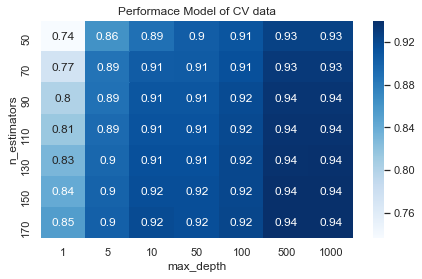

In [84]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cv, cmap="Blues", annot=True)
plt.title("Performace Model of CV data")

From the above plot,we can see that the best paraters are : n_estimarots:90,110,130,150,170,max_depth:500,1000

## Plotting the performance model for Train data

In [87]:
df_Train=pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'Train_AUC':train_auc})
data_Train=df_Train.pivot("n_estimators","max_depth","Train_AUC")

Text(0.5, 1, 'Performace Model of Train data')

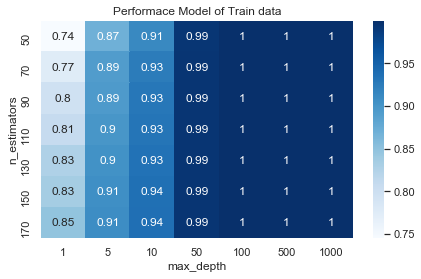

In [88]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(data_Train, cmap="Blues", annot=True)
plt.title("Performace Model of Train data")

From the above plot,we can see that the best parameters are: n_estimators : 90,110,130,150,170 and max_depth : 100,500,1000

## Building Random Forest model using best parameters

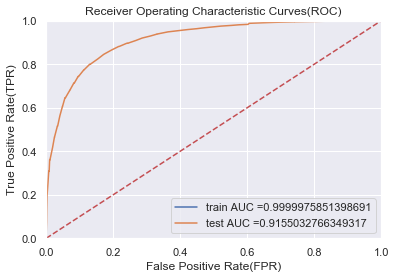

In [91]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=90,max_depth=1000,class_weight='balanced',random_state=3,n_jobs=-1)
RF.fit(X_train_bow,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  RF.predict_proba(X_train_bow)[:,1]
y_cv_pred =  RF.predict_proba(X_cv_bow)[:,1]
y_test_pred=RF.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, RF.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, RF.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting Confusion matrix using seaborn

In [48]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [93]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9984083469092435 for threshold 0.592

Train confusion matrix:

[[ 9808    15]
 [    3 46348]]

Test confusion matrix:

[[  854  1313]
 [  177 15211]]


In [94]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

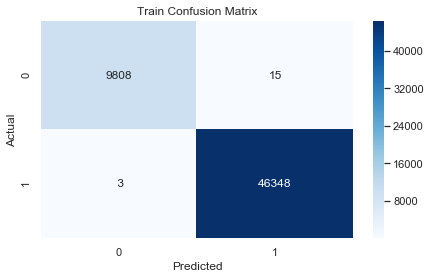

In [95]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

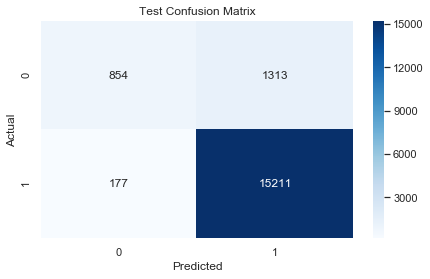

In [97]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Wordcloud of top 20 important features

In [99]:
features=RF.feature_importances_

In [100]:
Top20_features=features.argsort()
Top20_features

array([43902, 28072, 28068, ..., 22440, 16694, 25849], dtype=int64)

In [101]:
#Finding top 20 features
Top20_features=Top20_features[-20:]
Top20_features

array([18305, 11948, 42280, 39151, 21924, 38327, 43217, 22456, 43234,
       13843, 24510, 28181, 16353,  2727,  9975, 10787,  3545, 22440,
       16694, 25849], dtype=int64)

In [102]:
# printing the top 20  feature names

print(np.take(vectorizer.get_feature_names(),Top20_features))

['horrible' 'easy' 'waste' 'thought' 'like' 'taste' 'worst' 'loves'
 'would' 'favorite' 'money' 'perfect' 'good' 'bad' 'delicious'
 'disappointed' 'best' 'love' 'great' 'not']


In [103]:
Top20_features_Names=np.take(vectorizer.get_feature_names(),Top20_features)

In [104]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [105]:
Top20_features=Top20_features.head(20)

In [106]:
Top20_features['feature_names']=Top20_features_Names

In [107]:
Top20_features

,Indices,feature_names
13,2727,horrible
16,3545,easy
14,9975,waste
15,10787,thought
1,11948,like
9,13843,taste
12,16353,worst
18,16694,loves
0,18305,would
4,21924,favorite


## Plotting the Wordcloud of top 20 features

In [113]:
Top20_features_Names

array(['horrible', 'easy', 'waste', 'thought', 'like', 'taste', 'worst',
       'loves', 'would', 'favorite', 'money', 'perfect', 'good', 'bad',
       'delicious', 'disappointed', 'best', 'love', 'great', 'not'],
      dtype='<U79')

In [123]:
from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(Top20_features_Names))

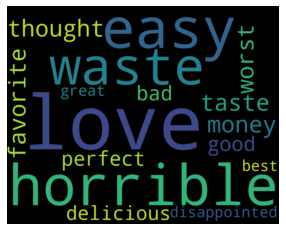

In [126]:
# Display the generated image:

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying Random Forests on TFIDF

In [127]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l1')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(56174, 500) (56174,)
(14044, 500) (14044,)
(17555, 500) (17555,)


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [128]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [129]:
# Estimator

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(class_weight='balanced',random_state=3,n_jobs=-1)

In [130]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(RF,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [131]:
RF_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 1000}

## Plotting Performace model for CV data

In [133]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
max_depth=[]
n_estimators=[]


for i in estimators:
    for j in depth:
        
        RF=RandomForestClassifier(n_estimators=i,max_depth=j,class_weight='balanced',random_state=4,n_jobs=-1)
        RF.fit(X_train_tfidf,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
        y_train_pred =  RF.predict_proba(X_train_tfidf)[:,1]
        y_cv_pred =  RF.predict_proba(X_cv_tfidf)[:,1]
        y_test_pred=RF.predict_proba(X_test_tfidf)[:,1]
    
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        n_estimators.append(i)
        max_depth.append(j)


In [134]:
df_cv_tfidf=pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'CV_AUC':cv_auc})
data_cv_tfidf=df_cv_tfidf.pivot("n_estimators","max_depth","CV_AUC")

Text(0.5, 1, 'Performace Model of CV data')

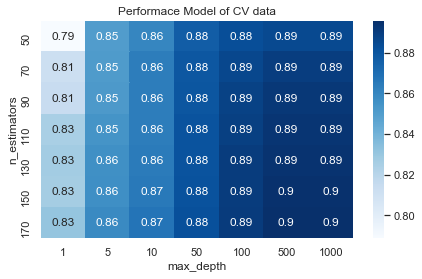

In [135]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cv_tfidf, cmap="Blues", annot=True)
plt.title("Performace Model of CV data")

From the above plot,we can see that the best parameters are: n_estimators:150,170,max_depth:500,1000

## Plotting the performance model for Train data

In [136]:
df_Train_tfidf=pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'Train_AUC':train_auc})
data_Train_tfidf=df_Train_tfidf.pivot("n_estimators","max_depth","Train_AUC")

Text(0.5, 1, 'Performace Model of Train data')

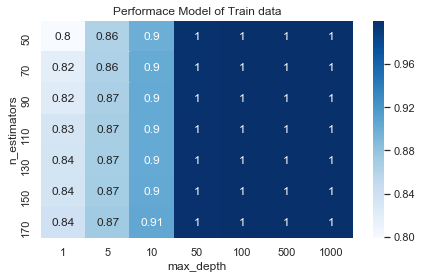

In [137]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(data_Train_tfidf, cmap="Blues", annot=True)
plt.title("Performace Model of Train data")

From the plot,we can see that the best parameters are: n_estimators:170,max_depth: 100,500,1000

## Building Random Forest model using best parameters

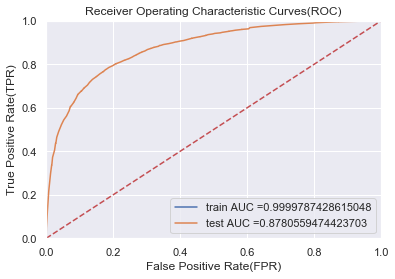

In [139]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=170,max_depth=1000,class_weight='balanced',random_state=3,n_jobs=-1)
RF.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  RF.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  RF.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=RF.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, RF.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, RF.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting Confusion matrix using seaborn

In [140]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9980598910482317 for threshold 0.566

Train confusion matrix:

[[ 9805    18]
 [    5 46346]]

Test confusion matrix:

[[  849  1318]
 [  485 14903]]


In [141]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

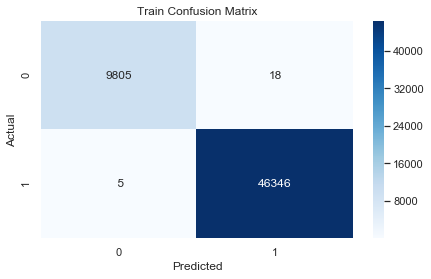

In [142]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

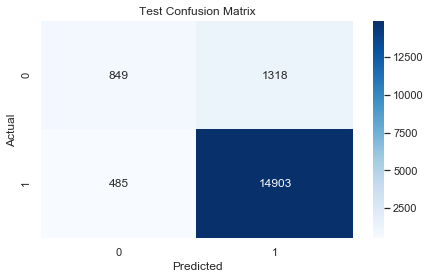

In [143]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

###  Wordcloud of top 20 important features

In [148]:
features_tfidf=RF.feature_importances_

In [149]:
Top20_features=features_tfidf.argsort()
Top20_features

array([172, 325,  86,  52, 124, 390, 201,  64,  66,  11,   2, 483, 414,
        46, 240, 167, 331, 304,  88,  65, 227, 224, 398,  57, 305, 423,
        99, 415, 108, 417, 111,   9, 298, 343,  70, 407, 328, 247, 371,
       168, 214, 131,  59, 181,  35, 338, 244, 326, 165,  98, 207,  92,
        20,  85, 471,  81, 233, 219,  97, 327, 434, 497,  36, 393, 480,
       107, 337, 342,  78, 413, 300, 430, 106, 101, 252, 134,  60, 293,
       205,  87, 255, 442, 193, 102, 353, 334, 277, 323, 209,  96, 220,
       112, 311, 401,  42, 397,  49,  24, 133, 226, 274, 484, 278, 479,
       472, 156,  58, 444, 190, 368, 419, 478, 140, 128, 283, 341, 319,
       412, 212, 268, 344, 486, 303,  91, 379, 235,  73, 388,   1, 473,
       146, 253, 285,  50, 281, 151, 428, 114, 375, 174, 184, 197, 230,
       163, 378,  18, 396, 150, 464,  37, 262, 416,  44,  77, 411,  80,
       179, 246, 188, 350, 105, 367,  45, 316, 385, 409, 306, 408, 100,
       470, 183, 222, 248, 158, 403, 329, 443, 215, 370, 195,  7

In [150]:
#Finding top 20 features
Top20_features=Top20_features[-20:]
Top20_features

array([135, 153, 452, 249, 436, 351, 164, 297, 284, 493, 266, 333,  30,
       125, 120, 199,  38, 264, 202, 301], dtype=int64)

In [151]:
# printing the top 20  feature names

print(np.take(tf_idf_vect.get_feature_names(),Top20_features))

['easy' 'excellent' 'thought' 'like' 'taste' 'product' 'favorite' 'nice'
 'money' 'would' 'loves' 'perfect' 'bad' 'disappointed' 'delicious' 'good'
 'best' 'love' 'great' 'not']


In [152]:
Top20_features_Names=np.take(tf_idf_vect.get_feature_names(),Top20_features)

In [153]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [154]:
Top20_features=Top20_features.head(20)

In [155]:
Top20_features['feature_names']=Top20_features_Names

In [156]:
Top20_features

,Indices,feature_names
12,30,easy
16,38,excellent
14,120,thought
13,125,like
0,135,taste
1,153,product
6,164,favorite
15,199,nice
18,202,money
3,249,would


## Plotting wordcloud of top 20 features

In [157]:
Top20_features_Names

array(['easy', 'excellent', 'thought', 'like', 'taste', 'product',
       'favorite', 'nice', 'money', 'would', 'loves', 'perfect', 'bad',
       'disappointed', 'delicious', 'good', 'best', 'love', 'great',
       'not'], dtype='<U12')

In [158]:
from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(Top20_features_Names))

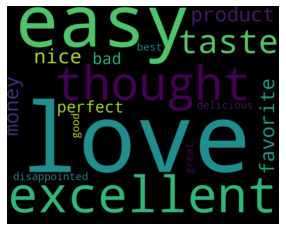

In [159]:
# Display the generated image:

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [161]:
#tfidf vectorizer using l2 regularization

tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l2')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(56174, 500) (56174,)
(14044, 500) (14044,)
(17555, 500) (17555,)


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [162]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [163]:
# Estimator

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(class_weight='balanced',random_state=3,n_jobs=-1)

In [164]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(RF,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [165]:
RF_RandomCV.best_params_

{'n_estimators': 130, 'max_depth': 500}

## Plotting Performace model for CV data

In [166]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
max_depth=[]
n_estimators=[]


for i in estimators:
    for j in depth:
        
        RF=RandomForestClassifier(n_estimators=i,max_depth=j,class_weight='balanced',random_state=5,n_jobs=-1)
        RF.fit(X_train_tfidf,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
        y_train_pred =  RF.predict_proba(X_train_tfidf)[:,1]
        y_cv_pred =  RF.predict_proba(X_cv_tfidf)[:,1]
        y_test_pred=RF.predict_proba(X_test_tfidf)[:,1]
    
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
        n_estimators.append(i)
        max_depth.append(j)


In [167]:
df_cv_tfidf_l2=pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'CV_AUC':cv_auc})
data_cv_tfidf_l2=df_cv_tfidf_l2.pivot("n_estimators","max_depth","CV_AUC")

Text(0.5, 1, 'Performace Model of CV data')

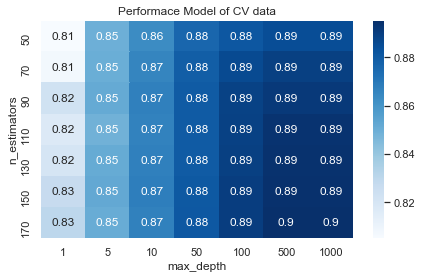

In [168]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cv_tfidf_l2, cmap="Blues", annot=True)
plt.title("Performace Model of CV data")

From the plot,we can see that the best parameters are :n_estimators:170,max_depth:500,1000

## Plotting the performance model for Train data

In [169]:
df_Train_tfidf_l2=pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'Train_AUC':train_auc})
data_Train_tfidf_l2=df_Train_tfidf_l2.pivot("n_estimators","max_depth","Train_AUC")

Text(0.5, 1, 'Performace Model of Train data')

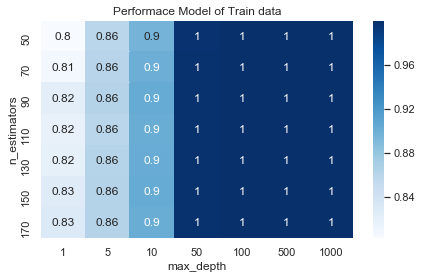

In [170]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(data_Train_tfidf_l2, cmap="Blues", annot=True)
plt.title("Performace Model of Train data")

From the plot,we can see that the best parameters are:n_estimators:50 to 170 and max_depth: 50 to 1000

## Building Random Forest model using best parameters

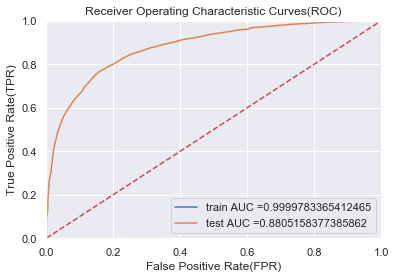

In [171]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=170,max_depth=500,class_weight='balanced',random_state=3,n_jobs=-1)
RF.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  RF.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  RF.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=RF.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, RF.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, RF.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting Confusion matrix using seaborn

In [172]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9980598910482317 for threshold 0.566

Train confusion matrix:

[[ 9805    18]
 [    5 46346]]

Test confusion matrix:

[[  847  1320]
 [  500 14888]]


In [173]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

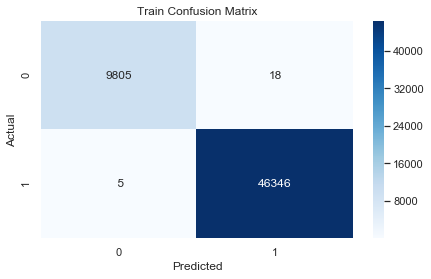

In [174]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

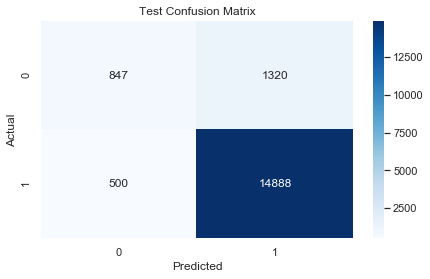

In [175]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

In [176]:
# Top 20 features for tfidf: le regularization
features_tfidf_l2=RF.feature_importances_

In [177]:
Top20_features=features_tfidf_l2.argsort()
Top20_features

array([201, 325, 414,  86,  66,  52, 305, 124,  46, 390, 172, 331,  88,
        64,  11, 483,   2, 240, 398, 227,  59, 423, 304, 407,  65, 207,
       415, 343,  57, 167, 298,  85, 224, 417,  70,  92, 168, 233,  99,
       326, 219, 371,  36, 327, 353,  35, 247, 244, 252, 413,  98, 181,
         9, 328, 255, 133, 165, 300, 107, 434, 334, 480, 337, 102, 101,
       214,  60,  97, 111, 108,  20, 134,  87, 393, 430, 131, 338, 193,
       442, 220, 209, 106, 323, 230,  81, 311, 140, 471, 205, 497, 341,
       112, 342, 283, 293, 277, 278,  96,  24, 128, 156, 253, 419, 396,
       388,  49, 303, 473, 486,  58, 472, 344,  50, 401, 319,  78, 478,
       274, 226, 479, 408, 151, 397, 484, 212,  42, 184,  37,  91, 375,
       190, 262, 368, 179, 428, 146, 105, 174, 268,  44, 367, 464, 114,
       350, 246, 409, 158, 150,  77, 412, 235, 163, 444, 385,  73, 470,
       416,   1, 188, 183,  33, 285,  18, 281, 403, 141, 197, 195, 316,
       378, 329, 100, 160,  82, 379, 307,  45, 306, 157,  28, 21

In [178]:
#Finding top 20 features
Top20_features=Top20_features[-20:]
Top20_features

array([153, 452, 135, 249, 436, 351, 164, 297, 493, 284, 266,  30, 333,
       125, 120, 199,  38, 264, 202, 301], dtype=int64)

In [179]:
# printing the top 20  feature names

print(np.take(tf_idf_vect.get_feature_names(),Top20_features))

['excellent' 'thought' 'easy' 'like' 'taste' 'product' 'favorite' 'nice'
 'would' 'money' 'loves' 'bad' 'perfect' 'disappointed' 'delicious' 'good'
 'best' 'love' 'great' 'not']


In [180]:
Top20_features_Names=np.take(tf_idf_vect.get_feature_names(),Top20_features)

In [181]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [182]:
Top20_features=Top20_features.head(20)

In [183]:
Top20_features['feature_names']=Top20_features_Names

In [184]:
Top20_features

,Indices,feature_names
11,30,excellent
16,38,thought
14,120,easy
13,125,like
2,135,taste
0,153,product
6,164,favorite
15,199,nice
18,202,would
3,249,money


## Plotting wordcloud of top 20 features  :l2 regularization

In [185]:
Top20_features_Names

array(['excellent', 'thought', 'easy', 'like', 'taste', 'product',
       'favorite', 'nice', 'would', 'money', 'loves', 'bad', 'perfect',
       'disappointed', 'delicious', 'good', 'best', 'love', 'great',
       'not'], dtype='<U12')

In [186]:
from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(Top20_features_Names))

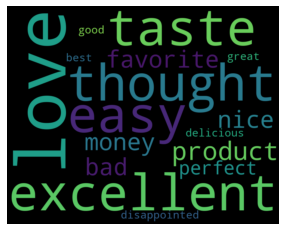

In [187]:
# Display the generated image:

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying Random Forests on AVG W2V

In [26]:
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [27]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [28]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14159
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'partner', 'happy', 'tea', 'feeling', 'much', 'better', 'since', 'starting', 'drink', 'drinking', 'hot', 'normal', 'iced', 'chilled', 'likes', 'refreshing', 'nature', 'chocolate', 'amazing', 'taste', 'smell', 'found', 'new', 'one', 'finest', 'maple', 'syrups', 'ordered', 'enjoyed', 'bought', 'fancy']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [192]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [193]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 56174/56174 [02:05<00:00, 448.40it/s]


In [194]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(56174, 50)
[-0.89445007 -0.17426153  0.3910916   0.01006085  1.00984683 -0.35039322
  0.70515896  0.55484738 -0.84969755  0.13529928  0.30668408 -0.24959334
 -0.67221517  0.10876214 -0.58556928  0.36978363  0.55279161  0.17655792
 -0.45695444 -0.28685245 -0.6090756  -0.48858902 -0.53971884 -0.21767239
 -0.34760382 -0.3784943  -0.2459354  -0.34068095  0.1042359   0.18923065
  1.09944339  0.1867113  -0.46287213  0.81341     0.68518911  0.65308171
 -0.51871094 -0.91553533 -0.59692018  0.07908438 -0.21159385  0.26551605
 -0.55219414  0.22785243  0.34824414 -0.20633671 -0.69893738  0.12338209
  0.43250735 -0.23093598]


## Converting CV data text

In [29]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [196]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|███████████████████████████████████████████████████████████████████████████| 14044/14044 [00:31<00:00, 444.53it/s]


In [197]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(14044, 50)
[-0.50282062 -0.52268306  0.08713933  0.43681118  0.72423249  0.25650907
  0.02421404  0.45356893 -0.33878565  0.07018882  0.17775434  0.00255587
 -0.1598513  -0.37784861 -0.47862561 -0.32925971 -0.56581464  0.56128567
 -0.48986703 -1.18553501 -0.30067849  0.23420971 -0.20612721 -0.56475859
 -0.32818317 -0.43920858  0.82443269 -0.31055568 -0.16059661 -0.04376315
  0.16385598  0.18798626 -0.60187782  0.83510412  0.03507625  0.35294379
  0.49965248 -0.27862616  0.03692137  0.22122478 -0.37707116 -0.34533242
 -0.02349559 -0.50305972 -0.61235497 -0.54005728 -0.04450938 -0.62475958
 -0.34271354  0.02134511]


## Converting Test data text

In [30]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [199]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:39<00:00, 445.98it/s]


(17555, 50)
[-0.0320667  -0.36568022  0.02954084  0.18100509  1.03177184  0.60551382
  0.38050661  0.52631758 -0.66273956  0.00596277  0.15476119  0.39214387
 -0.71783569  0.3161906  -0.32099725  0.54032777  0.22112885 -0.15771816
 -0.40761868 -1.13671994  0.34154425  0.24515377 -0.53301759 -0.42176097
 -1.27647447 -0.28859048  0.62013503  0.01154511  0.58044042 -0.61480519
  0.91906805 -0.08318872 -0.52591619  0.78420953  0.22787667  0.44413502
  0.45784863 -0.77483774 -0.34271306  0.34955951  0.66286164  0.52808888
 -0.44518706 -0.86589205  0.10394564 -0.14919354  0.58658501 -0.20715531
 -0.1800821  -0.60802993]


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [200]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [201]:
# Estimator

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(class_weight='balanced',random_state=4,n_jobs=-1)

In [202]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(RF,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(sent_vectors_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [203]:
RF_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 100}

## Building Random Forest model using best parameters

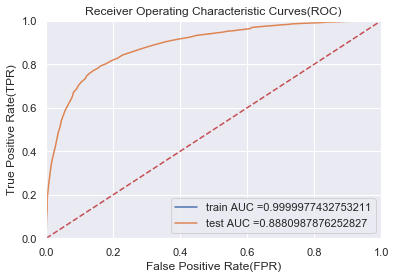

In [204]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=170,max_depth=100,class_weight='balanced',random_state=3,n_jobs=-1)
RF.fit(sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  RF.predict_proba(sent_vectors_train)[:,1]
y_cv_pred =  RF.predict_proba(sent_vectors_cv)[:,1]
y_test_pred=RF.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, RF.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, RF.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting Confusion matrix using seaborn

In [205]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9984083469092435 for threshold 0.588

Train confusion matrix:

[[ 9808    15]
 [    3 46348]]

Test confusion matrix:

[[  844  1323]
 [  543 14845]]


In [206]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

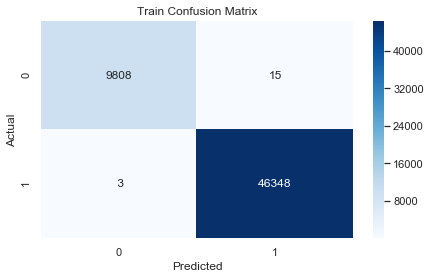

In [207]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

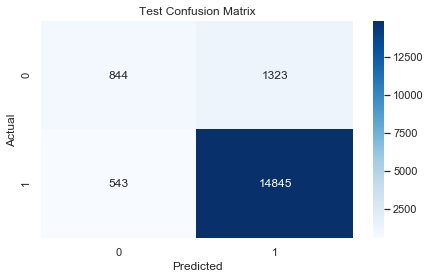

In [208]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

###  Applying Random Forests on TFIDF W2V

In [24]:
model = TfidfVectorizer(norm='l1')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [37:25<00:00, 28.19it/s]


In [34]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [35]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(56174, 50)
[-0.31065858  0.29508597  0.0275564  -0.63840965  0.71152003  0.74006608
  0.34653023  0.32345316  0.2766002   0.01908757 -0.10944537 -0.06502395
  0.62255722  0.09962216  0.29907266  0.23458565  0.52890978  0.05256887
 -0.08257613 -0.05567282 -0.43387066  0.02569291 -0.36426456 -0.50378763
  0.64616298 -0.16261987 -0.23448248  0.04954943 -0.74498862 -0.54222028
 -0.46769544 -0.27512712 -0.72415012  0.33729579  0.40904167  0.01144373
  0.21013097 -0.11091298 -0.31993302  0.23780811 -0.20685376 -0.18505029
  0.86167026  0.95427783  0.99628473  0.21876134  0.51395816 -0.41987431
 -0.73257074 -0.02515591]


## Converting CV data to tfidf-w2v

In [36]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using same dictioanry which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [08:51<00:00, 26.42it/s]


In [37]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [38]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(14044, 50)
[-0.33420028  1.27216074  0.22375549  0.42288682  0.09673416  0.36822206
  0.58827346 -0.61820606 -0.94494409  0.81408969  0.30618116  0.41507014
 -0.10814362 -0.46672275  0.22457866 -0.14228085  0.41279847 -0.0117452
 -0.21559993 -0.85053394  0.13729522 -0.56418407 -0.37087309  0.15871619
  0.0504615   0.27746826 -0.00357796 -0.36421054 -0.15181594 -0.3637501
 -0.27475296  0.12844019 -0.30728775  0.55646037 -0.34249271 -0.23753184
 -0.71524216 -0.07519849 -0.54240508 -0.11543325 -0.10421023 -0.68431418
  0.49623436  0.46797498  0.47681008  0.77382322 -0.32078858 -0.49440947
  0.27241846 -0.11896658]


## Converting Test data to tfidf-w2v

In [39]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using the same dictionary which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [11:04<00:00, 26.42it/s]


In [40]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [41]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(17555, 50)
[-0.87706691  0.61419091  0.17108203  0.09584619  0.25488533 -0.12430443
  0.80296554 -0.88299436  0.04109835  0.56442535 -0.38323769 -0.19085495
  0.68137094 -0.08128317  0.67124523  0.33946671  0.17963441  0.36074056
 -0.50588031 -1.0348437  -0.03248077 -0.00709779 -0.43313363 -0.17820594
  0.82855435  0.07991248  0.69034388  0.37455672 -0.59913888 -1.36807658
 -0.1154261  -0.34971719 -0.66230414  0.707087    0.84935883  0.16855507
 -0.16772542  0.45777572 -0.14827262  0.21357412 -0.48859954  0.13311523
  0.89270911 -0.18971119  0.1898408   0.20201378  0.55759246  0.20864846
  0.22599095 -0.40866396]


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [42]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [43]:
# Estimator

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(class_weight='balanced',random_state=6,n_jobs=-1)

In [44]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(RF,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [45]:
RF_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 100}

## Building Random Forest model using best parameters

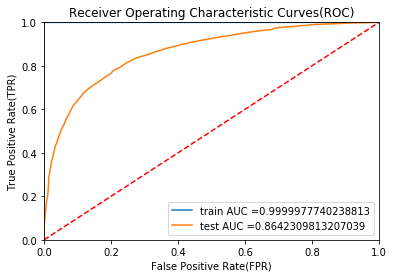

In [46]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=170,max_depth=100,class_weight='balanced',random_state=6,n_jobs=-1)
RF.fit(tfidf_sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  RF.predict_proba(tfidf_sent_vectors_train)[:,1]
y_cv_pred =  RF.predict_proba(tfidf_sent_vectors_cv)[:,1]
y_test_pred=RF.predict_proba(tfidf_sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, RF.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, RF.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

In [49]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9984083469092435 for threshold 0.583

Train confusion matrix:

[[ 9808    15]
 [    3 46348]]

Test confusion matrix:

[[  675  1492]
 [  407 14981]]


In [50]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

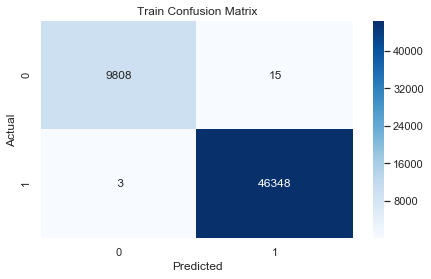

In [51]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

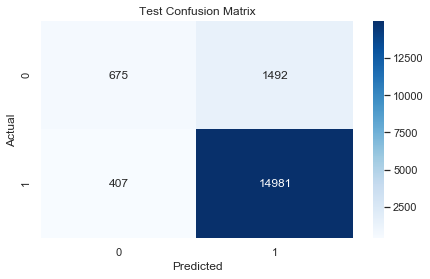

In [52]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

In [53]:
## tfidf vectorizer using l2 regularization

model = TfidfVectorizer(norm='l2')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [54]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [35:17<00:00, 26.52it/s]


In [55]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [56]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(56174, 50)
[-0.31065858  0.29508597  0.0275564  -0.63840965  0.71152003  0.74006608
  0.34653023  0.32345316  0.2766002   0.01908757 -0.10944537 -0.06502395
  0.62255722  0.09962216  0.29907266  0.23458565  0.52890978  0.05256887
 -0.08257613 -0.05567282 -0.43387066  0.02569291 -0.36426456 -0.50378763
  0.64616298 -0.16261987 -0.23448248  0.04954943 -0.74498862 -0.54222028
 -0.46769544 -0.27512712 -0.72415012  0.33729579  0.40904167  0.01144373
  0.21013097 -0.11091298 -0.31993302  0.23780811 -0.20685376 -0.18505029
  0.86167026  0.95427783  0.99628473  0.21876134  0.51395816 -0.41987431
 -0.73257074 -0.02515591]


## Converting CV data to tfidf-w2v

In [57]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using same dictioanry which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [09:51<00:00, 23.76it/s]


In [58]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [59]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(14044, 50)
[-0.33420028  1.27216074  0.22375549  0.42288682  0.09673416  0.36822206
  0.58827346 -0.61820606 -0.94494409  0.81408969  0.30618116  0.41507014
 -0.10814362 -0.46672275  0.22457866 -0.14228085  0.41279847 -0.0117452
 -0.21559993 -0.85053394  0.13729522 -0.56418407 -0.37087309  0.15871619
  0.0504615   0.27746826 -0.00357796 -0.36421054 -0.15181594 -0.3637501
 -0.27475296  0.12844019 -0.30728775  0.55646037 -0.34249271 -0.23753184
 -0.71524216 -0.07519849 -0.54240508 -0.11543325 -0.10421023 -0.68431418
  0.49623436  0.46797498  0.47681008  0.77382322 -0.32078858 -0.49440947
  0.27241846 -0.11896658]


## Converting Test data to tfidf-w2v

In [60]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using the same dictionary which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [10:23<00:00, 28.14it/s]


In [61]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [62]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(17555, 50)
[-0.87706691  0.61419091  0.17108203  0.09584619  0.25488533 -0.12430443
  0.80296554 -0.88299436  0.04109835  0.56442535 -0.38323769 -0.19085495
  0.68137094 -0.08128317  0.67124523  0.33946671  0.17963441  0.36074056
 -0.50588031 -1.0348437  -0.03248077 -0.00709779 -0.43313363 -0.17820594
  0.82855435  0.07991248  0.69034388  0.37455672 -0.59913888 -1.36807658
 -0.1154261  -0.34971719 -0.66230414  0.707087    0.84935883  0.16855507
 -0.16772542  0.45777572 -0.14827262  0.21357412 -0.48859954  0.13311523
  0.89270911 -0.18971119  0.1898408   0.20201378  0.55759246  0.20864846
  0.22599095 -0.40866396]


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [65]:
# Estimator

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(class_weight='balanced',random_state=10,n_jobs=-1)

In [66]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(RF,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

In [67]:
RF_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 500}

## Building Random Forest model using best parameters

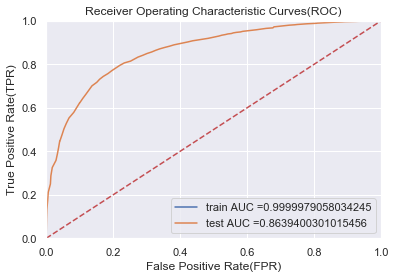

In [68]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(n_estimators=170,max_depth=500,class_weight='balanced',random_state=10,n_jobs=-1)
RF.fit(tfidf_sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  RF.predict_proba(tfidf_sent_vectors_train)[:,1]
y_cv_pred =  RF.predict_proba(tfidf_sent_vectors_cv)[:,1]
y_test_pred=RF.predict_proba(tfidf_sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, RF.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, RF.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

In [69]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9984083469092435 for threshold 0.588

Train confusion matrix:

[[ 9808    15]
 [    3 46348]]

Test confusion matrix:

[[  693  1474]
 [  427 14961]]


In [70]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

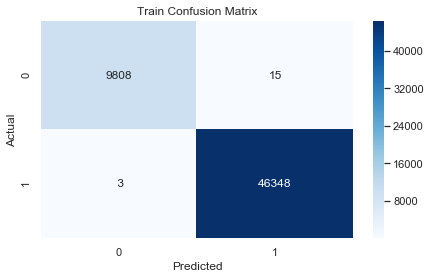

In [71]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

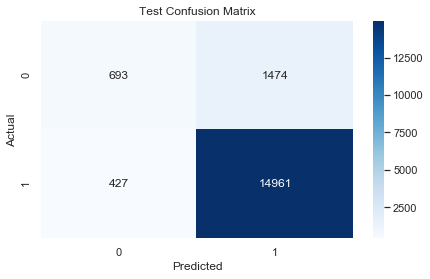

In [72]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Applying GBDT using XGBOOST

In [73]:
# Working with 50K points for brute force

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 30000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [74]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [75]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [76]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(28072, 10)

In [77]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.57333333333332

In [78]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


## Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [79]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [80]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(28072, 10)


1    23606
0     4466
Name: Score, dtype: int64

In [81]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [82]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [83]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [84]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 28072/28072 [00:13<00:00, 2126.36it/s]


In [85]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [86]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...


## Sorting the data in descending order beased on Time Column

In [87]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [88]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
8731,9564,B001EQ5IPQ,AA2104NO2VE8H,Lakshminarayan Iyer,0,0,0,1351209600,Extremely dissapointed,"Hi,<br />I am very disappointed with the past ...",hi disappointed past shipment received one coc...
14526,15842,B007TJGZ5E,A3UOYYQS5Z47MS,"David A. Levin ""DaveL""",0,0,1,1351209600,Morning Coffee,Great coffee at a good price. I'm a subscripti...,great coffee good price subscription buyer buy...
15069,16426,B007TJGZ54,A29BJSTYH9W3JI,Harry,0,0,1,1351209600,super coffee,Great coffee and so easy to brew. This coffee...,great coffee easy brew coffee great aroma good...
7451,8135,B0019GVYR2,ACSO5EDO1UMZ5,SeekingBodhi,0,0,0,1351209600,NEWSFLASH,I just called Bob's Red Mill customer service ...,called bob red mill customer service g search ...
7156,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,0,1351209600,Don't like the taste,I do not like sour taste and this has a sour k...,not like sour taste sour kind taste not like s...
7620,8322,B003VXFK44,A3GFZIL1E0Z5V8,bloomen1,0,0,1,1351209600,Rodeo Drive is Crazy Good Coffee!,Rodeo Drive is my absolute favorite and I'm re...,rodeo drive absolute favorite ready order find...
25112,27424,B003WEFSAI,A37O0JPLJ8BOXP,Texaschick59,0,0,1,1351209600,Drink mix,We love this drink mix it taste delicious and ...,love drink mix taste delicious impossible yo f...
22401,24518,B0016JJEFG,AO9WE22147CRH,Arvind Rajan,0,0,0,1351209600,bad tasting tea,We drink a lot of tea... from all over the wor...,drink lot tea world far worst tasting tea purc...


In [89]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [90]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
9,healthy dog food good digestion also good smal...,1
8731,hi disappointed past shipment received one coc...,0
14526,great coffee good price subscription buyer buy...,1
15069,great coffee easy brew coffee great aroma good...,1


In [91]:
final_df.shape

(28072, 2)

In [92]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [93]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.20,random_state=3,shuffle=False) 
X_train, X_cv, y_train, y_cv= train_test_split(X_train, y_train, test_size=0.20,random_state=3,shuffle=False) 

In [94]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(17965,) (17965,)
(4492,) (4492,)
(5615,) (5615,)


### Applying XGBOOST on BOW

In [25]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(17965, 24459) (17965,)
(4492, 24459) (4492,)
(5615, 24459) (5615,)


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [27]:
params_grid

{'max_depth': [1, 5, 10, 50, 100, 500, 1000],
 'n_estimators': [50, 70, 90, 110, 130, 150, 170]}

In [28]:
# Estimator

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=3,n_jobs=-1)

In [29]:
# Building RandomizedsSearchCV

RF_RandomCV=RandomizedSearchCV(xgb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
RF_RandomCV.fit(X_train_bow,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=3, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
         

In [30]:
RF_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 50}

## Building XGBOOST model using best parameters

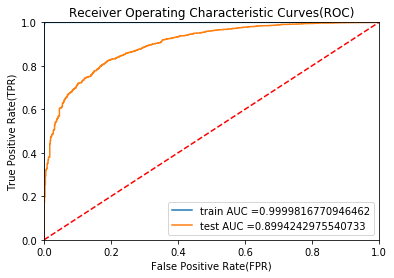

In [32]:
from xgboost import XGBClassifier
XGB=XGBClassifier(n_estimators=170,max_depth=50,random_state=4,n_jobs=-1)
XGB.fit(X_train_bow,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  XGB.predict_proba(X_train_bow)[:,1]
y_cv_pred =  XGB.predict_proba(X_cv_bow)[:,1]
y_test_pred=XGB.predict_proba(X_test_bow)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, XGB.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, XGB.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting Confusion matrix using seaborn

In [33]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [34]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9978276125567046 for threshold 0.588

Train confusion matrix:

[[ 3037     6]
 [    3 14919]]

Test confusion matrix:

[[ 344  421]
 [ 147 4703]]


In [35]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

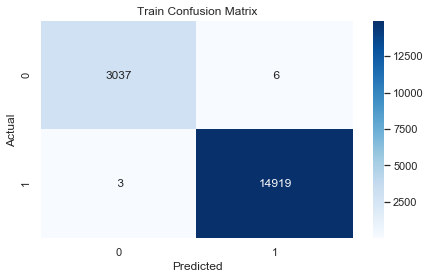

In [36]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

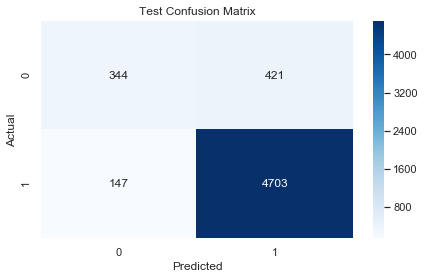

In [37]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Wordcloud of top 20 important features


In [39]:
features=XGB.feature_importances_

In [40]:
Top20_features=features.argsort()
Top20_features

array([    0, 16058, 16057, ..., 23603,  5371, 18053], dtype=int64)

In [41]:
#Finding top 20 features
Top20_features=Top20_features[-20:]
Top20_features

array([12561, 22474,  7854, 23782,  6679, 14267, 12220,  1431, 13698,
        6106, 15664, 21849, 18406, 21723, 24104,  5644, 12054, 23603,
        5371, 18053], dtype=int64)

In [42]:
# printing the top 20  feature names

print(np.take(vectorizer.get_feature_names(),Top20_features))

['loves' 'tug' 'february' 'whatsoever' 'dumped' 'nice' 'life' 'awful'
 'money' 'disappointed' 'perfect' 'threw' 'rubber' 'theory' 'worst'
 'delicious' 'leaking' 'waste' 'dangerous' 'return']


In [43]:
Top20_features_Names=np.take(vectorizer.get_feature_names(),Top20_features)

In [44]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [45]:
Top20_features=Top20_features.head(20)

In [46]:
Top20_features['feature_names']=Top20_features_Names

In [47]:
Top20_features

,Indices,feature_names
7,1431,loves
18,5371,tug
15,5644,february
9,6106,whatsoever
4,6679,dumped
2,7854,nice
16,12054,life
6,12220,awful
0,12561,money
8,13698,disappointed


## Plotting the Wordcloud of top 20 features

In [48]:
Top20_features_Names

array(['loves', 'tug', 'february', 'whatsoever', 'dumped', 'nice', 'life',
       'awful', 'money', 'disappointed', 'perfect', 'threw', 'rubber',
       'theory', 'worst', 'delicious', 'leaking', 'waste', 'dangerous',
       'return'], dtype='<U45')

In [49]:
from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(Top20_features_Names))

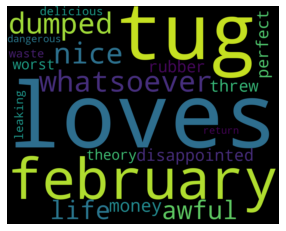

In [50]:
# Display the generated image:

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying XGBOOST on TFIDF

In [51]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l1')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(17965, 500) (17965,)
(4492, 500) (4492,)
(5615, 500) (5615,)


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [52]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [53]:
# Estimator

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=4,n_jobs=-1)

In [55]:
# Building RandomizedsSearchCV

xgb_RandomCV=RandomizedSearchCV(xgb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
xgb_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=4, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
         

In [56]:
xgb_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 500}

## Building XGBOOST model using best parameters

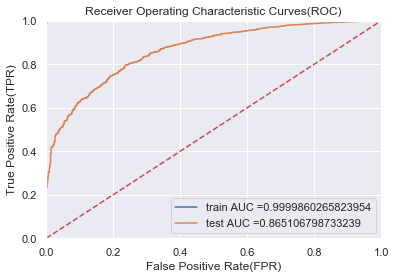

In [57]:
from xgboost import XGBClassifier
XGB=XGBClassifier(n_estimators=170,max_depth=500,random_state=5,n_jobs=-1)
XGB.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  XGB.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  XGB.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=XGB.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, XGB.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, XGB.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting confusion matrix using seaborn

In [58]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9990141307919816 for threshold 0.737

Train confusion matrix:

[[ 3040     3]
 [    0 14922]]

Test confusion matrix:

[[ 383  382]
 [ 338 4512]]


In [59]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

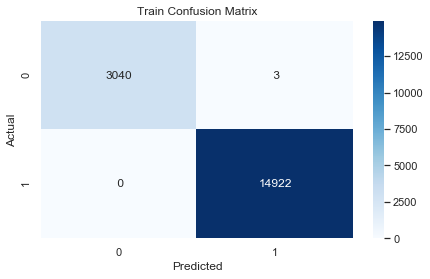

In [60]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

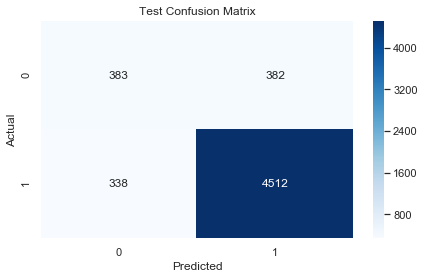

In [61]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Wordcloud of top 20 important features

In [62]:
features=XGB.feature_importances_

In [63]:
Top20_features=features.argsort()
Top20_features

array([104, 395,  32,  94, 392, 101, 471, 470, 179,  11,  78, 340, 439,
       469, 124, 129, 244, 236, 243, 442,  96, 273, 324, 145, 428, 140,
       416, 405,  33, 394, 303, 415, 342, 192, 113, 452, 220, 100, 162,
       265, 412, 122,  61,  86, 184, 483,  24, 288, 242,  10,  60, 491,
       422, 459, 389, 434, 419,  22, 175, 345, 468, 119, 496, 486, 285,
       229, 414, 167,  87, 493, 131, 360, 172,  55,  40, 200,   0,  98,
       210, 271, 350, 445, 349,  57,  64, 169, 263, 365, 180, 408, 460,
       371, 251, 325, 136, 375, 187, 385,   5, 318, 193, 158, 164, 213,
       364, 431, 309,  41,  76, 432, 466, 308,  15, 159,  88, 250,   4,
       477, 178, 425, 465, 123, 151, 248, 337, 339, 352, 467, 334,  80,
       374, 474, 433, 188, 344, 314,  90, 185,  95, 383, 300,  85, 278,
       485, 311, 254,  62, 216, 390, 111,   1, 144, 295, 462, 376, 199,
         3, 195,  30, 174, 240, 370, 301, 170,  74, 166, 458, 109, 267,
       449, 286,  70, 346, 106, 181, 457, 481, 429, 231, 490, 24

In [64]:
#Finding top 20 features
Top20_features=Top20_features[-20:]
Top20_features

array([148,  83,  39, 307, 197, 163, 259, 160, 212, 274, 335, 177,  29,
        84,  34, 293, 329, 280, 116, 121], dtype=int64)

In [65]:
# printing the top 20  feature names

print(np.take(tf_idf_vect.get_feature_names(),Top20_features))

['excellent' 'clean' 'best' 'opened' 'great' 'finally' 'loves' 'favorite'
 'highly' 'microwave' 'plastic' 'french' 'bad' 'cocoa' 'bar' 'nice'
 'perfect' 'money' 'delicious' 'disappointed']


In [66]:
Top20_features_Names=np.take(tf_idf_vect.get_feature_names(),Top20_features)

In [67]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [68]:
Top20_features=Top20_features.head(20)

In [69]:
Top20_features['feature_names']=Top20_features_Names

In [70]:
Top20_features

,Indices,feature_names
12,29,excellent
14,34,clean
2,39,best
1,83,opened
13,84,great
18,116,finally
19,121,loves
0,148,favorite
7,160,highly
5,163,microwave


## Plotting the Wordcloud of top 20 features

In [71]:
Top20_features_Names

array(['excellent', 'clean', 'best', 'opened', 'great', 'finally',
       'loves', 'favorite', 'highly', 'microwave', 'plastic', 'french',
       'bad', 'cocoa', 'bar', 'nice', 'perfect', 'money', 'delicious',
       'disappointed'], dtype='<U12')

In [72]:
from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(Top20_features_Names))

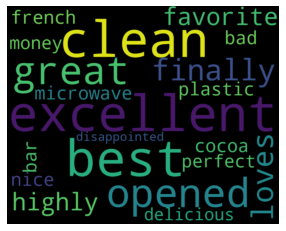

In [73]:
# Display the generated image:

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [74]:
## Tfidf vectorizer using l2 regularization

tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500,norm='l2')
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(17965, 500) (17965,)
(4492, 500) (4492,)
(5615, 500) (5615,)


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [75]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [76]:
# Estimator

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=5,n_jobs=-1)

In [77]:
# Building RandomizedsSearchCV

xgb_RandomCV=RandomizedSearchCV(xgb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
xgb_RandomCV.fit(X_train_tfidf,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=5, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
         

In [79]:
xgb_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 50}

## Building XGBOOST model using best parameters

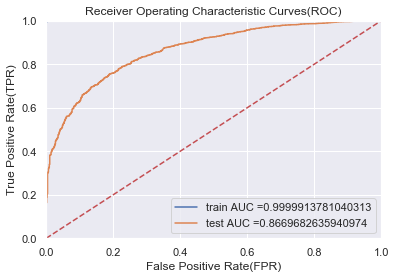

In [80]:
from xgboost import XGBClassifier
XGB=XGBClassifier(n_estimators=170,max_depth=50,random_state=6,n_jobs=-1)
XGB.fit(X_train_tfidf,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  XGB.predict_proba(X_train_tfidf)[:,1]
y_cv_pred =  XGB.predict_proba(X_cv_tfidf)[:,1]
y_test_pred=XGB.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, XGB.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, XGB.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

In [81]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.998813283560218 for threshold 0.711

Train confusion matrix:

[[ 3040     3]
 [    3 14919]]

Test confusion matrix:

[[ 358  407]
 [ 316 4534]]


In [82]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

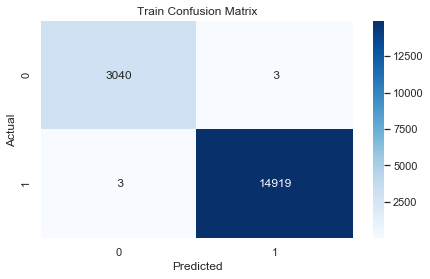

In [83]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

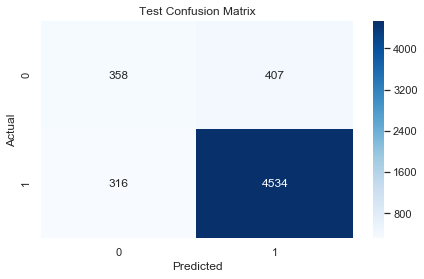

In [84]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Wordcloud of top 20 important features

In [85]:
features=XGB.feature_importances_

In [86]:
Top20_features=features.argsort()
Top20_features

array([473, 221,  83, 204, 104, 403, 440, 209, 294, 418,  60, 340, 428,
       274,  35,  88, 101, 242, 463, 320, 244, 483,  55, 318, 334,  59,
        11, 395, 485,  32, 413,   5, 330, 303, 199,  91, 452, 140, 470,
       113,  34,  70, 179, 124,  90, 371, 219, 374, 180,  94, 389, 145,
       176, 112,  81, 175, 117, 187, 493, 341, 364, 415, 184,   8, 200,
       265, 248, 459,  57,  64, 339, 434, 314, 119, 232, 422, 342,  96,
       268,  74, 166,  86, 122, 181,  10, 167, 251, 220,  16, 412, 271,
       189,  95, 210, 131,  15, 263, 159,  24,  61, 458, 216, 332, 243,
       448, 146, 419, 447, 172,  40, 138, 300, 308, 100, 111,  45, 234,
       405, 439, 327, 162, 158, 170, 201, 106, 350, 169, 383, 460, 240,
       471, 285, 237,  33,  68, 309, 360, 192, 254, 295, 370, 132, 466,
       311, 367, 474, 426, 108, 191, 198, 264, 445, 396, 465, 193, 384,
       490, 156, 178, 349, 276, 467, 411, 491, 287, 394,   1, 123, 102,
       404, 203, 143, 126,  36, 129, 250, 324, 267, 479, 380, 24

In [87]:
#Finding top 20 features
Top20_features=Top20_features[-20:]
Top20_features

array([ 14,  25, 257, 494, 335, 489, 197, 148, 438, 272,  39, 160, 212,
       228, 259, 293, 329, 280, 116, 121], dtype=int64)

In [88]:
# printing the top 20  feature names

print(np.take(tf_idf_vect.get_feature_names(),Top20_features))

['amazing' 'away' 'love' 'wrong' 'plastic' 'wonderful' 'great' 'excellent'
 'tasty' 'meat' 'best' 'favorite' 'highly' 'jerky' 'loves' 'nice'
 'perfect' 'money' 'delicious' 'disappointed']


In [89]:
Top20_features_Names=np.take(vectorizer.get_feature_names(),Top20_features)

In [90]:
# Creating a dataframe for the top 20 features

Top20_features=pd.DataFrame(Top20_features,columns=['Indices'])
Top20_features=Top20_features.sort_values(by='Indices',ascending=True)

In [91]:
Top20_features=Top20_features.head(20)

In [92]:
Top20_features['feature_names']=Top20_features_Names

In [93]:
Top20_features

,Indices,feature_names
0,14,abandoned
1,25,ability
10,39,adem
18,116,aj
19,121,advertizing
7,148,airtight
11,160,activists
6,197,achieved
12,212,agriculture
13,228,adjective


## Plotting the Wordcloud of top 20 features

In [94]:
Top20_features_Names

array(['abandoned', 'ability', 'adem', 'aj', 'advertizing', 'airtight',
       'activists', 'achieved', 'agriculture', 'adjective', 'abroad',
       'acidophilus', 'acustom', 'addendum', 'adequate', 'admitted',
       'advertisements', 'adjustments', 'according', 'accounted'],
      dtype='<U45')

In [95]:
from wordcloud import WordCloud
word_cloud=WordCloud(width=1000,height=800,background_color='black').generate(' '.join(Top20_features_Names))

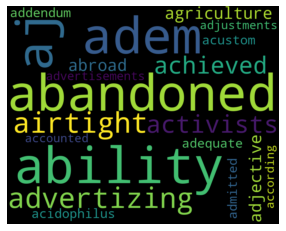

In [96]:
# Display the generated image:

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying XGBOOST on AVG W2V

In [95]:
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [96]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [97]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [98]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7968
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'healthy', 'dog', 'food', 'good', 'digestion', 'also', 'small', 'puppies', 'eats', 'required', 'amount', 'every', 'feeding', 'hi', 'disappointed', 'past', 'shipment', 'received', 'one', 'coconut', 'water', 'boxes', 'leaking', 'spoiled', 'thanks', 'great', 'coffee', 'price', 'subscription', 'buyer', 'buy']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [101]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [102]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 17965/17965 [00:27<00:00, 663.09it/s]


In [103]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(17965, 50)
[-0.52719977  0.26064394 -0.1370816  -0.6546296   0.17830508  0.42053562
  0.46242192 -0.0947991  -0.72627853 -0.26061293 -0.38790706  0.42943522
  0.40731279  0.30663971 -0.05110275  0.66431616 -0.0073343   0.38588119
  0.44244967 -0.2403099  -0.06842122 -0.59271086 -0.38531999  0.07650527
 -0.41089553 -0.33635914 -0.09446975  0.03975418  0.243335   -0.41105689
 -0.481017   -0.03866332  0.77295335  0.24176987 -0.13515304  0.3014871
  0.54781975  0.53036311 -0.17773945 -0.09915078 -0.24981823 -0.29841296
  0.34348488 -0.63186066  0.43065967  0.80515035  0.14895043 -0.09988685
 -0.55116533  0.58065831]


## Converting CV data text

In [99]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [105]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|█████████████████████████████████████████████████████████████████████████████| 4492/4492 [00:06<00:00, 644.13it/s]


In [106]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(4492, 50)
[-0.76675088 -0.07834271 -0.0624547  -0.66257989  0.85993389  0.03969445
  0.29125366 -0.46498002 -0.11073245  0.1162494  -0.17794204  0.49560479
  0.33266829 -0.43013713 -0.18752738  0.29606567  0.29241277  0.32703951
  0.73527709 -0.45489918  0.18728543 -0.06991681  0.00721731  0.05581555
 -0.22816193  0.11778065 -0.43213531  0.4581352   0.0442897  -0.70780119
  0.44272155  0.63963236  0.21586613  0.08057581 -0.10611172  0.62677046
  0.96844444 -0.48480947  0.08298399 -0.96535251 -0.4817927  -0.73021999
  0.35279202  0.04948434  0.02171564  0.2519132   0.56066259 -0.98976183
 -0.42916308  0.44856734]


## Converting Test data text

In [100]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [108]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5615/5615 [00:10<00:00, 472.06it/s]


(5615, 50)
[-0.57527079  0.05977945 -0.57061724 -0.35489743  0.23784624 -0.08144549
  0.34215566  0.06862068 -0.42639341 -0.06022287 -0.50214234  0.13708592
  0.83143102 -0.0931668  -0.32032749  0.89462052 -0.05995526  1.11149267
  0.25447856  0.01316345 -0.01750803 -0.41640853 -0.25222165 -0.21769281
 -0.34452465 -0.0393424  -0.29530992  0.06760169  0.12771954 -0.13813791
  0.45277424 -0.03041251  0.73164107  0.1306643  -0.00262923  0.38723662
  0.23388908  0.4335287  -0.29752836 -0.2301444  -0.50225227 -0.61332
  0.49132335 -0.10411869  0.73188093  0.90221027  0.06094555 -0.15804063
 -1.04007192  0.26787528]


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [109]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [110]:
# Estimator

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=6,n_jobs=-1)

In [112]:
# Building RandomizedsSearchCV

xgb_RandomCV=RandomizedSearchCV(xgb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
xgb_RandomCV.fit(sent_vectors_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=6, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
         

In [113]:
xgb_RandomCV.best_params_

{'n_estimators': 130, 'max_depth': 5}

## Building XGBOOST model using best parameters

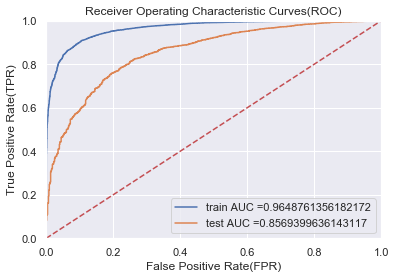

In [114]:
from xgboost import XGBClassifier
XGB=XGBClassifier(n_estimators=130,max_depth=5,random_state=6,n_jobs=-1)
XGB.fit(sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  XGB.predict_proba(sent_vectors_train)[:,1]
y_cv_pred =  XGB.predict_proba(sent_vectors_cv)[:,1]
y_test_pred=XGB.predict_proba(sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, XGB.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, XGB.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

In [115]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8134015579666913 for threshold 0.756

Train confusion matrix:

[[ 2725   318]
 [ 1368 13554]]

Test confusion matrix:

[[ 498  267]
 [ 612 4238]]


In [116]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

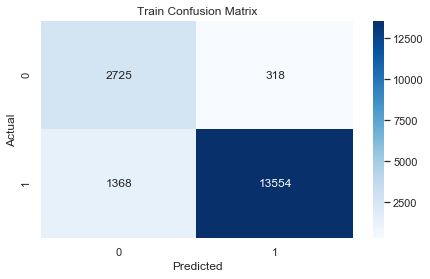

In [117]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

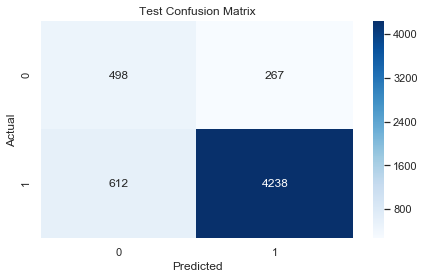

In [118]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying XGBOOST on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [101]:
model = TfidfVectorizer(norm='l1')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [102]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17965/17965 [04:17<00:00, 69.74it/s]


In [103]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [104]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(17965, 50)
[-0.81849976  0.51121209 -0.19035238 -0.29304554  0.3788981   0.11320409
 -0.03951613 -0.32853426  0.43079403  0.10575645  0.07789934 -0.33508741
  0.05824741 -0.44508208  0.39565444 -0.32905655  0.33301993  0.28321353
 -0.28053581 -0.28252613 -0.16071037  0.6074405  -0.68100251 -0.25343899
  0.15341803 -0.40399016 -0.62080374  0.04478222 -0.07313738 -0.14339399
 -0.56716065  0.31906318  0.04896114  0.09588383  0.01023043 -0.09872376
 -0.11446195 -0.12910985  0.10906195  0.17774718 -0.566546   -0.18708618
  0.3493718   0.31580985  0.77629789  0.3174748   0.47287742 -0.29513071
 -0.55419817 -0.07820649]


## Converting CV data to tfidf-w2v

In [105]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using same dictioanry which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4492/4492 [01:08<00:00, 65.81it/s]


In [106]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [107]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(4492, 50)
[-0.94452473  0.87968858 -0.41653324  0.40023324 -0.02855035 -0.292049
  0.47842321 -0.86843141 -0.69171763 -0.00456736  0.63811181 -0.15119725
  0.23221027 -0.44356204  0.84239084 -0.25589632  0.49118547  0.07919897
  0.06557083 -0.52787635  0.18539942  0.20672194 -0.09854132 -0.06456202
  0.29598862 -0.40360497 -0.03154317  0.2941675  -0.55755945 -0.18588514
 -0.73122271  0.67751299 -0.22556831  0.17189    -0.06976115 -0.27502571
 -0.63247352  0.4219092   0.13509874 -0.08424075 -0.84548816  0.28264719
 -0.52049687  0.08500336  0.21112695  0.03955832  0.31068305 -0.445041
  0.41668549 -1.01715907]


## Converting Test data to tfidf-w2v

In [108]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using the same dictionary which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5615/5615 [01:31<00:00, 61.62it/s]


In [109]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [110]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(5615, 50)
[-0.5541104   0.70658989 -0.08596564 -0.43333989  0.31012787 -0.00170163
  0.04484265 -0.24163485  1.44899042 -0.16324367  0.69407854 -0.06779867
 -0.42321344 -1.29054105  0.39987682 -0.55958785  0.53261098  0.60506738
  0.09042159 -0.70275507 -0.04696983  0.63582396 -0.76610023  0.14072521
 -0.46485299 -0.4811656  -0.41390523  0.21547566  0.10928029  0.02746789
 -1.00328989  0.61748626  0.46302836 -0.24398367 -0.0741278  -0.58181918
  0.15423506  0.22818275 -0.34618732 -0.01957229 -0.42933163 -0.44579566
 -0.75887089  0.20975739  0.61731681  0.10591537 -0.32652603 -0.0747231
 -0.13805476  0.10165115]


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [111]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [112]:
# Estimator

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=8,n_jobs=-1)

In [113]:
# Building RandomizedsSearchCV

xgb_RandomCV=RandomizedSearchCV(xgb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
xgb_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=8, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
         

In [114]:
xgb_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 5}

## Building Decision Tree using best the parameters

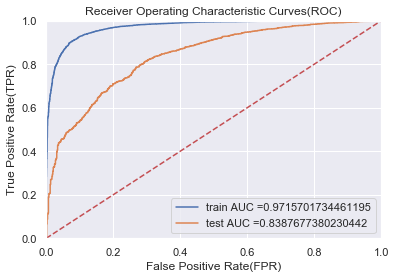

In [115]:
from xgboost import XGBClassifier
XGB=XGBClassifier(n_estimators=170,max_depth=5,random_state=8,n_jobs=-1)
XGB.fit(tfidf_sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  XGB.predict_proba(tfidf_sent_vectors_train)[:,1]
y_cv_pred =  XGB.predict_proba(tfidf_sent_vectors_cv)[:,1]
y_test_pred=XGB.predict_proba(tfidf_sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, XGB.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, XGB.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

In [116]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8368780887694554 for threshold 0.768

Train confusion matrix:

[[ 2808   235]
 [ 1389 13533]]

Test confusion matrix:

[[ 482  283]
 [ 694 4156]]


In [117]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

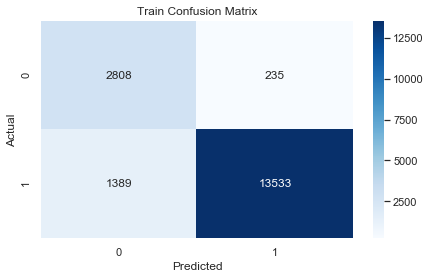

In [118]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

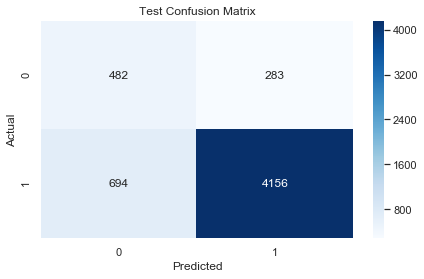

In [119]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

In [120]:
## tfidf vectorizer using l2 regularization

model = TfidfVectorizer(norm='l2')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [121]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17965/17965 [04:55<00:00, 60.71it/s]


In [122]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [123]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(17965, 50)
[-0.81849976  0.51121209 -0.19035238 -0.29304554  0.3788981   0.11320409
 -0.03951613 -0.32853426  0.43079403  0.10575645  0.07789934 -0.33508741
  0.05824741 -0.44508208  0.39565444 -0.32905655  0.33301993  0.28321353
 -0.28053581 -0.28252613 -0.16071037  0.6074405  -0.68100251 -0.25343899
  0.15341803 -0.40399016 -0.62080374  0.04478222 -0.07313738 -0.14339399
 -0.56716065  0.31906318  0.04896114  0.09588383  0.01023043 -0.09872376
 -0.11446195 -0.12910985  0.10906195  0.17774718 -0.566546   -0.18708618
  0.3493718   0.31580985  0.77629789  0.3174748   0.47287742 -0.29513071
 -0.55419817 -0.07820649]


## Converting CV data to tfidf-w2v

In [124]:

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using same dictioanry which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4492/4492 [01:12<00:00, 61.79it/s]


In [125]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [126]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(4492, 50)
[-0.94452473  0.87968858 -0.41653324  0.40023324 -0.02855035 -0.292049
  0.47842321 -0.86843141 -0.69171763 -0.00456736  0.63811181 -0.15119725
  0.23221027 -0.44356204  0.84239084 -0.25589632  0.49118547  0.07919897
  0.06557083 -0.52787635  0.18539942  0.20672194 -0.09854132 -0.06456202
  0.29598862 -0.40360497 -0.03154317  0.2941675  -0.55755945 -0.18588514
 -0.73122271  0.67751299 -0.22556831  0.17189    -0.06976115 -0.27502571
 -0.63247352  0.4219092   0.13509874 -0.08424075 -0.84548816  0.28264719
 -0.52049687  0.08500336  0.21112695  0.03955832  0.31068305 -0.445041
  0.41668549 -1.01715907]


## Converting Test data to tfidf-w2v

In [127]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))# Using the same dictionary which is created for train
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5615/5615 [01:37<00:00, 57.85it/s]


In [128]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [129]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(5615, 50)
[-0.5541104   0.70658989 -0.08596564 -0.43333989  0.31012787 -0.00170163
  0.04484265 -0.24163485  1.44899042 -0.16324367  0.69407854 -0.06779867
 -0.42321344 -1.29054105  0.39987682 -0.55958785  0.53261098  0.60506738
  0.09042159 -0.70275507 -0.04696983  0.63582396 -0.76610023  0.14072521
 -0.46485299 -0.4811656  -0.41390523  0.21547566  0.10928029  0.02746789
 -1.00328989  0.61748626  0.46302836 -0.24398367 -0.0741278  -0.58181918
  0.15423506  0.22818275 -0.34618732 -0.01957229 -0.42933163 -0.44579566
 -0.75887089  0.20975739  0.61731681  0.10591537 -0.32652603 -0.0747231
 -0.13805476  0.10165115]


## Hyperparameter tuning to find best "# of estimators" and 'max_depth"' using RandomizedSearchCV

In [130]:
from sklearn.model_selection import RandomizedSearchCV
# Assigning values to the parameters
depth=[1, 5, 10, 50, 100, 500, 1000]
estimators=[50,70,90,110,130,150,170]
params_grid=dict(max_depth=depth,n_estimators=estimators)

In [131]:
# Estimator

from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=10,n_jobs=-1)

In [132]:
# Building RandomizedsSearchCV

xgb_RandomCV=RandomizedSearchCV(xgb,params_grid,cv=3,scoring='roc_auc',n_jobs=-1)
xgb_RandomCV.fit(tfidf_sent_vectors_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=10, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
        

In [134]:
xgb_RandomCV.best_params_

{'n_estimators': 170, 'max_depth': 5}

## Building Decision Tree using best the parameters

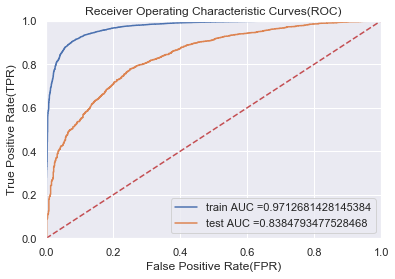

In [137]:
from xgboost import XGBClassifier
XGB=XGBClassifier(n_estimators=170,max_depth=5,random_state=10,n_jobs=-1,base_score=0.6)
XGB.fit(tfidf_sent_vectors_train,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred =  XGB.predict_proba(tfidf_sent_vectors_train)[:,1]
y_cv_pred =  XGB.predict_proba(tfidf_sent_vectors_cv)[:,1]
y_test_pred=XGB.predict_proba(tfidf_sent_vectors_test)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, XGB.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds_te = roc_curve(y_test, XGB.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()

## Plotting confusion matrix using seaborn

In [138]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.8348491573423559 for threshold 0.771

Train confusion matrix:

[[ 2807   236]
 [ 1417 13505]]

Test confusion matrix:

[[ 477  288]
 [ 688 4162]]


In [139]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

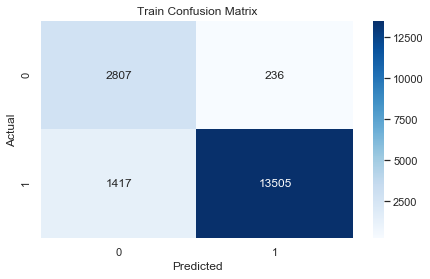

In [140]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

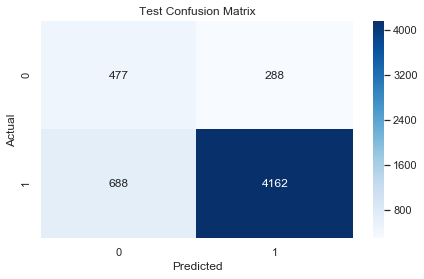

In [141]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

# Conclusions

In [142]:
# Conclusions for Random Forest

In [143]:
from prettytable import PrettyTable

In [144]:
x=PrettyTable()

In [145]:
x.field_names=['Vectorizer','Regularization','n_estimators','max_depth','AUC']

In [146]:
x.add_row(['BOW','-',90,1000,91.55])
x.add_row(['TFIDF','L1',170,1000,87.80])
x.add_row(['TFIDF','L2',130,500,88.05])
x.add_row(['AVGW2V','-',170,100,80.80])
x.add_row(['TFIDF_AVGW2V','L1',170,500,86.42])
x.add_row(['TFIDF_AVGW2V','L2',170,500,86.39])

In [147]:
print(x)

+--------------+----------------+--------------+-----------+-------+
|  Vectorizer  | Regularization | n_estimators | max_depth |  AUC  |
+--------------+----------------+--------------+-----------+-------+
|     BOW      |       -        |      90      |    1000   | 91.55 |
|    TFIDF     |       L1       |     170      |    1000   |  87.8 |
|    TFIDF     |       L2       |     130      |    500    | 88.05 |
|    AVGW2V    |       -        |     170      |    100    |  80.8 |
| TFIDF_AVGW2V |       L1       |     170      |    500    | 86.42 |
| TFIDF_AVGW2V |       L2       |     170      |    500    | 86.39 |
+--------------+----------------+--------------+-----------+-------+


In [148]:
# Conclusions for XGBOOST

In [149]:
x=PrettyTable()

In [150]:
x.field_names=['Vectorizer','Regularization','n_estimators','max_depth','AUC']

In [151]:
x.add_row(['BOW','-',170,50,89.94])
x.add_row(['TFIDF','L1',170,500,86.51])
x.add_row(['TFIDF','L2',170,50,88.69])
x.add_row(['AVGW2V','-',130,5,85.69])
x.add_row(['TFIDF_AVGW2V','L1',170,5,83.87])
x.add_row(['TFIDF_AVGW2V','L2',170,5,83.84])

In [152]:
print(x)

+--------------+----------------+--------------+-----------+-------+
|  Vectorizer  | Regularization | n_estimators | max_depth |  AUC  |
+--------------+----------------+--------------+-----------+-------+
|     BOW      |       -        |     170      |     50    | 89.94 |
|    TFIDF     |       L1       |     170      |    500    | 86.51 |
|    TFIDF     |       L2       |     170      |     50    | 88.69 |
|    AVGW2V    |       -        |     130      |     5     | 85.69 |
| TFIDF_AVGW2V |       L1       |     170      |     5     | 83.87 |
| TFIDF_AVGW2V |       L2       |     170      |     5     | 83.84 |
+--------------+----------------+--------------+-----------+-------+
